<a href="https://colab.research.google.com/github/financieras/ai/blob/main/logistic_regression/jupyter/prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regession
Proceso completo de entrenamiento y predicción con datos de test (salvo estadística descriptiva y gráficos).

## Normalizar dataset
Partimos de un archivo CSV y lo limpiamos, seleccionamos columnas y normalizamos.

Los archivos de origen están en Drive y son:
- 'datasets/dataset_train.csv'
- 'datasets/dataset_test.csv'

Los archivos están en Google Drive por lo que lo leemos y construimos un DataFrame. En esta primera fase vamos a trabajar solo con los datos de entrenamiento.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Ruta al archivo en Google Drive
input_file = '/content/drive/My Drive/datasets/dataset_train.csv'

# Leer el archivo CSV y crear el DataFrame
df = pd.read_csv(input_file)

# Mostrar información sobre las columnas del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Index                          1600 non-null   int64  
 1   Hogwarts House                 1600 non-null   object 
 2   First Name                     1600 non-null   object 
 3   Last Name                      1600 non-null   object 
 4   Birthday                       1600 non-null   object 
 5   Best Hand                      1600 non-null   object 
 6   Arithmancy                     1566 non-null   float64
 7   Astronomy                      1568 non-null   float64
 8   Herbology                      1567 non-null   float64
 9   Defense Against the Dark Arts  1569 non-null   float64
 10  Divination                     1561 non-null   float64
 11  Muggle Studies                 1565 non-null   float64
 12  Ancient Runes                  1565 non-null   f

In [3]:
# Borrar la columna 'Astronomy'
df = df.drop(columns=['Astronomy'])

In [4]:
# Convert 'Birthday' to datetime format
df['Birthday'] = pd.to_datetime(df['Birthday'])

# Convert 'Best Hand' to a binary variable (0 for Left, 1 for Right)
df['Best Hand'] = df['Best Hand'].map({'Left': 0, 'Right': 1})

# Reset the index to a continuous sequence
df = df.reset_index(drop=True)

# Remove the original 'Index' column if it exists
if 'Index' in df.columns:
    df = df.drop('Index', axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Hogwarts House                 1600 non-null   object        
 1   First Name                     1600 non-null   object        
 2   Last Name                      1600 non-null   object        
 3   Birthday                       1600 non-null   datetime64[ns]
 4   Best Hand                      1600 non-null   int64         
 5   Arithmancy                     1566 non-null   float64       
 6   Herbology                      1567 non-null   float64       
 7   Defense Against the Dark Arts  1569 non-null   float64       
 8   Divination                     1561 non-null   float64       
 9   Muggle Studies                 1565 non-null   float64       
 10  Ancient Runes                  1565 non-null   float64       
 11  History of Magic 

## Normalización
Es crucial usar EXACTAMENTE los mismos parámetros de normalización (media y desviación estándar) que se usen para los datos de entrenamiento cuando se aplique la normalización a los datos de test. No se deben calcular nuevos parámetros con los datos de test.

In [5]:
# Calculate age based on the maximum date in Birthday column
df['Birthday'] = pd.to_datetime(df['Birthday'])
reference_date = df['Birthday'].max()
df['Age'] = (reference_date - df['Birthday']).dt.days / 365.25

# Remove unnecessary columns
columns_to_drop = ['First Name', 'Last Name', 'Birthday']
df = df.drop(columns=columns_to_drop)

# Select numerical columns to normalize (including Age which is already float64)
columns_to_normalize = df.select_dtypes(include=['float64']).columns.tolist()

# Function to normalize using mean and standard deviation
def normalize(column, mean=None, std=None):
    """
    Normaliza una columna usando media y desviación estándar

    Parámetros:
    column: columna a normalizar
    mean: media preexistente (opcional)
    std: desviación estándar preexistente (opcional)

    Retorna:
    Si mean y std son None:
        column_normalized, mean, std
    Si mean y std son proporcionados:
        column_normalized
    """
    if mean is None or std is None:
        mean = column.mean()
        std = column.std()
        return (column - mean) / std, mean, std
    return (column - mean) / std

# Diccionario para guardar los parámetros de normalización
normalization_params = {}

# Aplicar normalización y guardar parámetros
for column in columns_to_normalize:
    df[column], mean, std = normalize(df[column])
    normalization_params[column] = {'mean': mean, 'std': std}


# Apply one-hot encoding for Hogwarts House
df = pd.get_dummies(df, columns=['Hogwarts House'], prefix='House', dtype=float)

# Convert int values in 'Best Hand' column to float64 values
df['Best Hand'] = df['Best Hand'].astype(float)


print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Best Hand                      1600 non-null   float64
 1   Arithmancy                     1566 non-null   float64
 2   Herbology                      1567 non-null   float64
 3   Defense Against the Dark Arts  1569 non-null   float64
 4   Divination                     1561 non-null   float64
 5   Muggle Studies                 1565 non-null   float64
 6   Ancient Runes                  1565 non-null   float64
 7   History of Magic               1557 non-null   float64
 8   Transfiguration                1566 non-null   float64
 9   Potions                        1570 non-null   float64
 10  Care of Magical Creatures      1560 non-null   float64
 11  Charms                         1600 non-null   float64
 12  Flying                         1600 non-null   f

In [6]:
# Remove columns
reduce_columns = ['Arithmancy', 'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic', 'Transfiguration', 'Care of Magical Creatures']
df = df.drop(columns=reduce_columns)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Best Hand                      1600 non-null   float64
 1   Herbology                      1567 non-null   float64
 2   Defense Against the Dark Arts  1569 non-null   float64
 3   Potions                        1570 non-null   float64
 4   Charms                         1600 non-null   float64
 5   Flying                         1600 non-null   float64
 6   Age                            1600 non-null   float64
 7   House_Gryffindor               1600 non-null   float64
 8   House_Hufflepuff               1600 non-null   float64
 9   House_Ravenclaw                1600 non-null   float64
 10  House_Slytherin                1600 non-null   float64
dtypes: float64(11)
memory usage: 137.6 KB
None


In [7]:
# Drop rows with missing data
df = df.dropna()

# Remove duplicate rows
df = df.drop_duplicates()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1508 entries, 0 to 1599
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Best Hand                      1508 non-null   float64
 1   Herbology                      1508 non-null   float64
 2   Defense Against the Dark Arts  1508 non-null   float64
 3   Potions                        1508 non-null   float64
 4   Charms                         1508 non-null   float64
 5   Flying                         1508 non-null   float64
 6   Age                            1508 non-null   float64
 7   House_Gryffindor               1508 non-null   float64
 8   House_Hufflepuff               1508 non-null   float64
 9   House_Ravenclaw                1508 non-null   float64
 10  House_Slytherin                1508 non-null   float64
dtypes: float64(11)
memory usage: 141.4 KB
None


## Variables del modelo

In [8]:
import numpy as np

# 1. Crear la matriz y con todas las casas ya que estoy en un caso de clasificación multinomial
y = df[['House_Gryffindor', 'House_Hufflepuff', 'House_Ravenclaw', 'House_Slytherin']]

# 2. Seleccionar las características (X)
X = df[['Best Hand', 'Age', 'Herbology', 'Defense Against the Dark Arts',
        'Potions', 'Charms', 'Flying']]

# 3. Agregar columna de 1's para el término de sesgo (bias)
X = np.c_[np.ones(len(X)), X]

# Convertir a arrays de numpy para operaciones más eficientes
X = np.array(X)
y = np.array(y)

print("\nPrimeros 3 valores de X:")
print(X[:3])

print("\nPrimeros 3 valores de y:")
print(y[:3])


Primeros 3 valores de X:
[[ 1.          0.         -0.65312594  0.87862839  1.01034582 -0.68618295
   1.20455291 -0.50032993]
 [ 1.          1.         -0.33150337 -1.36568958  1.13345528  0.41246159
  -1.00298294 -1.3869281 ]
 [ 1.          0.         -0.36979177  1.26137897  0.7766708   0.88255609
   1.82518401  0.08667263]]

Primeros 3 valores de y:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


## Función Sofmax
- Para un caso multinomial, en lugar de la función sigmoide, es recomendado usar la función softmax.  
- La función sigmoide se usa principalmente para clasificación binaria, mientras que softmax es la generalización para múltiples clases.
- La función softmax se define como:
- softmax(z)_i = exp(z_i) / Σ(exp(z_j))

In [9]:
def softmax(z):
    """
    Calcula la función softmax para clasificación multinomial

    Parámetros:
    z: matriz de forma (n_muestras, n_clases)

    Retorna:
    matriz de probabilidades de forma (n_muestras, n_clases)
    donde cada fila suma 1
    """
    # Restamos el máximo para estabilidad numérica
    # Esto evita desbordamiento en exp() con números grandes
    z_shifted = z - np.max(z, axis=1, keepdims=True)

    # Calculamos exp() de los valores desplazados
    exp_scores = np.exp(z_shifted)

    # Normalizamos dividiendo por la suma
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Podemos probar la función con algunos valores
test_values = np.array([
    [1, 2, 3, 4],
    [2, 1, 0, -1],
    [0, 0, 0, 0]
])
print("Valores de prueba:\n", test_values)
print("\nProbabilidades softmax:\n", softmax(test_values))
print("\nVerificar que cada fila suma 1:\n", np.sum(softmax(test_values), axis=1))

Valores de prueba:
 [[ 1  2  3  4]
 [ 2  1  0 -1]
 [ 0  0  0  0]]

Probabilidades softmax:
 [[0.0320586  0.08714432 0.23688282 0.64391426]
 [0.64391426 0.23688282 0.08714432 0.0320586 ]
 [0.25       0.25       0.25       0.25      ]]

Verificar que cada fila suma 1:
 [1. 1. 1.]


## Función de pérdida
- Para el caso multinomial, necesitamos adaptar la función de pérdida para manejar múltiples clases.
- La función de pérdida logarítmica multinomial también se llama cross-entropy.

In [10]:
def compute_cost(X, y, W):
    """
    Calcula la función de pérdida logarítmica (cross-entropy) para clasificación multinomial

    Parámetros:
    X: matriz de características (incluyendo columna de 1's) de forma (n_muestras, n_características)
    y: matriz one-hot de etiquetas reales de forma (n_muestras, n_clases)
    W: matriz de pesos de forma (n_características, n_clases)

    Retorna:
    J: valor de la función de pérdida
    """
    m = X.shape[0]  # número de muestras

    # Calcular predicciones
    z = np.dot(X, W)  # (n_muestras, n_clases)
    h = softmax(z)    # (n_muestras, n_clases)

    # Calcular pérdida logarítmica
    epsilon = 1e-15  # para evitar log(0)

    # Multiplicación elemento a elemento de y real con log de predicciones
    # y sumamos sobre todas las clases (axis=1) y todas las muestras
    J = -(1/m) * np.sum(y * np.log(h + epsilon))

    return J

# Ejemplo de uso:
# Supongamos que tenemos:
# X: (1508, 8) - 1508 muestras, 7 características + 1 columna de unos
# y: (1508, 4) - etiquetas one-hot para 4 casas
# W: (8, 4) - pesos para cada característica y cada clase

# Inicializar pesos aleatoriamente
W = np.random.randn(X.shape[1], y.shape[1]) * 0.01

# Calcular coste inicial
cost = compute_cost(X, y, W)
print(f"Coste inicial: {cost}")

Coste inicial: 1.3883844709926232


Las principales diferencias con la versión binaria son:
- Usamos W (matriz de pesos) en lugar de theta (vector)
- Usamos softmax en lugar de sigmoid
- La fórmula de la pérdida es más simple porque y es one-hot encoding (solo el término positivo importa)
- No necesitamos el término (1-y) porque las etiquetas ya están en formato one-hot

Esta función de pérdida penalizará más cuando el modelo asigne probabilidades bajas a las clases correctas y nos servirá para entrenar el modelo mediante descenso por gradiente.

## Descenso del Gradiente
Para el caso multinomial, necesitamos adaptar la función de descenso del gradiente para manejar la matriz de pesos W en lugar del vector theta.

In [11]:
def gradient_descent_multinomial(X, y, learning_rate=0.1, num_iterations=1000, epsilon=1e-8):
    """
    Implementa el descenso del gradiente para regresión logística multinomial

    Parámetros:
    X: matriz de características (incluyendo columna de 1's) de forma (n_muestras, n_características)
    y: matriz one-hot de etiquetas reales de forma (n_muestras, n_clases)
    learning_rate: tasa de aprendizaje (alpha)
    num_iterations: número máximo de iteraciones
    epsilon: umbral para early stopping

    Retorna:
    W: matriz de pesos optimizada
    cost_history: lista con el valor de la función de pérdida en cada iteración
    """
    # Inicializar matriz de pesos W con valores pequeños aleatorios
    n_features = X.shape[1]
    n_classes = y.shape[1]
    W = np.random.randn(n_features, n_classes) * 0.01

    # Lista para guardar el historial de costes
    cost_history = []

    # Número de muestras
    m = X.shape[0]

    # Calcular coste inicial
    prev_cost = compute_cost(X, y, W)
    cost_history.append(prev_cost)

    # Descenso del gradiente
    for i in range(num_iterations):
        # Calcular predicciones actuales
        z = np.dot(X, W)
        h = softmax(z)

        # Calcular gradiente
        # El gradiente es (1/m) * X^T * (h - y)
        gradient = (1/m) * np.dot(X.T, (h - y))

        # Actualizar pesos
        W = W - learning_rate * gradient

        # Calcular nuevo coste
        current_cost = compute_cost(X, y, W)
        cost_history.append(current_cost)

        # Imprimir progreso cada 1000 iteraciones
        if i % 1000 == 0:
            print(f'Iteración {i}: Coste = {current_cost}')

        # Early stopping
        if abs(prev_cost - current_cost) < epsilon:
            print(f'\nConvergencia alcanzada en la iteración {i}')
            print(f'Diferencia en coste: {abs(prev_cost - current_cost)}')
            break

        prev_cost = current_cost

    return W, cost_history

# Ejemplo de uso:
# W, cost_history = gradient_descent_multinomial(X, y)

Las principales diferencias con la versión binomial son:
- Inicializamos una matriz W en lugar de un vector theta
- El gradiente se calcula usando la fórmula para multinomial: (1/m) * X^T * (h - y)
    - h son las probabilidades softmax
    - La resta (h - y) se hace sobre todas las clases

No necesitamos una función compute_gradient separada, ya que el cálculo es más directo
Todas las operaciones matriciales están adaptadas para manejar múltiples clases

Para hacer predicciones con el modelo entrenado, podrías usar:

In [12]:
def predict(X, W):
    """
    Realiza predicciones usando los pesos aprendidos

    Parámetros:
    X: matriz de características (incluyendo columna de 1's)
    W: matriz de pesos optimizada

    Retorna:
    predicciones: matriz de probabilidades para cada clase
    """
    z = np.dot(X, W)
    return softmax(z)

podemos ejecutarlo así:

Iteración 0: Coste = 1.2784162846377933
Iteración 1000: Coste = 0.11580846486949116
Iteración 2000: Coste = 0.11169811045218087
Iteración 3000: Coste = 0.10982765402311696
Iteración 4000: Coste = 0.10870494480604345
Coste inicial: 1.36877507087773
Coste final: 0.10791250314891968

Precisión del modelo: 0.9834


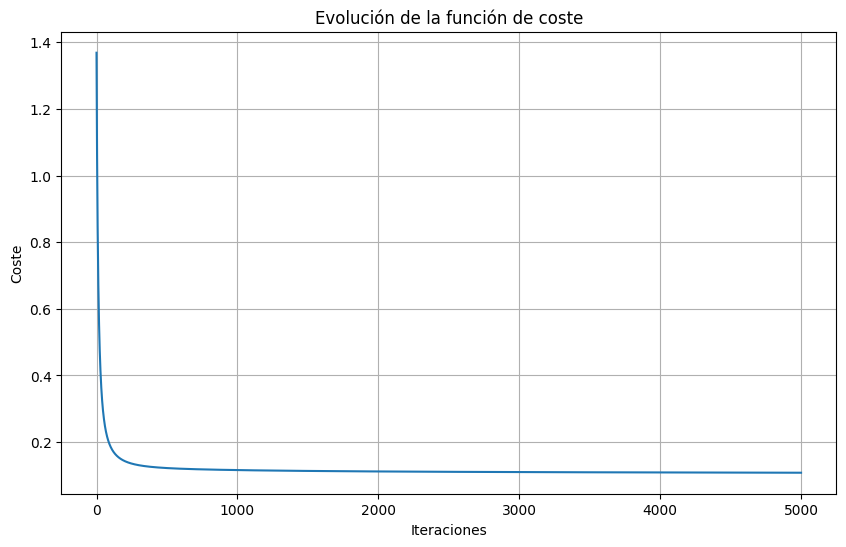

In [13]:
# Hiperparámetros
learning_rate = 0.1
num_iterations = 5_000

# Ejecutar el descenso del gradiente multinomial
W_optimal, cost_history = gradient_descent_multinomial(X, y, learning_rate, num_iterations)

# Imprimir coste inicial y final
print(f"Coste inicial: {cost_history[0]}")
print(f"Coste final: {cost_history[-1]}")

# Hacer predicciones
probabilities = predict(X, W_optimal)

# Obtener la clase predicha
predicted_houses = np.argmax(probabilities, axis=1)
actual_houses = np.argmax(y, axis=1)
accuracy = np.mean(predicted_houses == actual_houses)
print(f"\nPrecisión del modelo: {accuracy:.4f}")

# Visualizar la evolución del coste
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Evolución de la función de coste')
plt.xlabel('Iteraciones')
plt.ylabel('Coste')
plt.grid(True)
plt.show()

# Tratamiento de los datos de test

Primero cargar los datos de test:

In [14]:
import pandas as pd

# Ruta al archivo en Google Drive para test
input_file_test = '/content/drive/My Drive/datasets/dataset_test.csv'

# Leer el archivo CSV y crear el DataFrame de test
df_test = pd.read_csv(input_file_test)

print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Index                          400 non-null    int64  
 1   Hogwarts House                 0 non-null      float64
 2   First Name                     400 non-null    object 
 3   Last Name                      400 non-null    object 
 4   Birthday                       400 non-null    object 
 5   Best Hand                      400 non-null    object 
 6   Arithmancy                     387 non-null    float64
 7   Astronomy                      387 non-null    float64
 8   Herbology                      389 non-null    float64
 9   Defense Against the Dark Arts  392 non-null    float64
 10  Divination                     394 non-null    float64
 11  Muggle Studies                 390 non-null    float64
 12  Ancient Runes                  392 non-null    flo

## Procesamiento de los datos de `test`
Comentario para la posterior: Imputación de datos faltantes

Vamos a tratar los datos de test igual que los datos de entrenamiento salvo que no vamos a eliminar columnas de las asignaturas, ni siguiera eliminaremos 'Astronomy' ya que aprovecharemos esta información para realizar la imputación de los datos faltantes usando regresión múltiple.

El caso de 'Astronomy' es importante ya que mantiene con 'Defense Against the Dark Arts' una correlación perfecta con r=-1, lo cual nos ayudará a imputar bastantes datos con precisión total. Simplemnete dividiendo entre -100 los catos de 'Astronomy' se obtienen los datos de 'Defense Against the Dark Arts'.



In [15]:
# Convert 'Birthday' to datetime format
df_test['Birthday'] = pd.to_datetime(df_test['Birthday'])

# Convert 'Best Hand' to a binary variable (0 for Left, 1 for Right)
df_test['Best Hand'] = df_test['Best Hand'].map({'Left': 0, 'Right': 1})


# Remove unnecessary columns
columns_to_drop = ['First Name', 'Last Name', 'Birthday', 'Hogwarts House']
df_test = df_test.drop(columns=columns_to_drop)

print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Index                          400 non-null    int64  
 1   Best Hand                      400 non-null    int64  
 2   Arithmancy                     387 non-null    float64
 3   Astronomy                      387 non-null    float64
 4   Herbology                      389 non-null    float64
 5   Defense Against the Dark Arts  392 non-null    float64
 6   Divination                     394 non-null    float64
 7   Muggle Studies                 390 non-null    float64
 8   Ancient Runes                  392 non-null    float64
 9   History of Magic               389 non-null    float64
 10  Transfiguration                389 non-null    float64
 11  Potions                        390 non-null    float64
 12  Care of Magical Creatures      392 non-null    flo

## Normalización de los datos de test
- Normalizar los datos de test usando los parámetros (media y desviación estándar) que guardamos del conjunto de entrenamiento.
- Esto es crucial porque debemos aplicar exactamente la misma transformación que aplicamos a los datos de entrenamiento.

In [ ]:
# Convertir Best Hand a float64 como hicimos en training
df_test['Best Hand'] = df_test['Best Hand'].astype(float)

# Normalizar usando los parámetros guardados de training
for column in df_test.columns:
    if column in normalization_params:
        mean = normalization_params[column]['mean']
        std = normalization_params[column]['std']
        df_test[column] = normalize(df_test[column], mean, std)

print("\nPrimeros 3 registros después de la normalización:")
print(df_test.head(3))


Primeros 3 registros después de la normalización:
   Best Hand  Herbology  Defense Against the Dark Arts   Potions    Charms  \
0        1.0   0.360013                      -1.260955 -0.724744 -0.126065   
1        0.0   0.349486                       0.785819  0.814602  1.375558   
2        0.0  -1.403671                      -0.540051 -1.302330 -1.095106   

     Flying       Age  
0 -0.364411 -1.719458  
1 -0.493877  0.897554  
2  1.825147  0.418949  
